In [1]:
# 1. Import Libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report
)
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:

# 2. Load Dataset
df = pd.read_csv(r"C:\Users\biswa\classification_problem\loan_approval_pred\data\train.csv")
df.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [3]:
# 3. Encode Categorical Features
df['cb_person_default_on_file'] = df['cb_person_default_on_file'].map({'Y': 1, 'N': 0})
label_cols = ['person_home_ownership', 'loan_intent', 'loan_grade']
le = LabelEncoder()
for col in label_cols:
    df[col] = le.fit_transform(df[col])


In [4]:

# 4. Feature Scaling
scaler = StandardScaler()
num_cols = ['person_age', 'person_income', 'person_emp_length',
            'loan_amnt', 'loan_int_rate', 'loan_percent_income',
            'cb_person_cred_hist_length']
df[num_cols] = scaler.fit_transform(df[num_cols])


In [5]:

# 5. Train-Test Split
X = df.drop(['id', 'loan_status'], axis=1)
y = df['loan_status']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [6]:

# 6. Train XGBoost Model
xgb = XGBClassifier(eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [7]:

# 7. Predict
y_pred = xgb.predict(X_test)
y_prob = xgb.predict_proba(X_test)[:, 1]


 XGBoost Classifier Evaluation:
----------------------------------------
Accuracy : 0.9505499190041777
Precision: 0.9025110782865583
Recall   : 0.7317365269461078
F1 Score : 0.8082010582010583
ROC-AUC  : 0.9524185747205262

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.97     10059
           1       0.90      0.73      0.81      1670

    accuracy                           0.95     11729
   macro avg       0.93      0.86      0.89     11729
weighted avg       0.95      0.95      0.95     11729



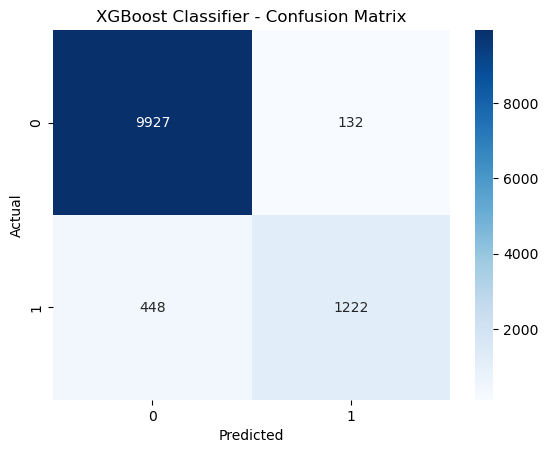

In [8]:

# 8. Evaluation Function
def evaluate_model(y_true, y_pred, y_prob, title="XGBoost Classifier"):
    print(f" {title} Evaluation:")
    print("-" * 40)
    print("Accuracy :", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall   :", recall_score(y_true, y_pred))
    print("F1 Score :", f1_score(y_true, y_pred))
    print("ROC-AUC  :", roc_auc_score(y_true, y_prob))
    print("\nClassification Report:\n", classification_report(y_true, y_pred))

    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{title} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

evaluate_model(y_test, y_pred, y_prob)


In [9]:
import os

def save_result_to_csv(model_name, acc, prec, rec, f1, roc):
    result = pd.DataFrame([{
        'model_name': model_name,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1_score': f1,
        'roc_auc': roc
    }])

    dir_path = r"C:\Users\biswa\classification_problem\loan_approval_pred\comparison_of_all"
    file_path = os.path.join(dir_path, "comparison.csv")

    os.makedirs(dir_path, exist_ok=True)

    if os.path.exists(file_path):
        result.to_csv(file_path, mode='a', header=False, index=False)
    else:
        result.to_csv(file_path, index=False)


In [10]:
save_result_to_csv(
    model_name="xgb", 
    acc=accuracy_score(y_test, y_pred),
    prec=precision_score(y_test, y_pred),
    rec=recall_score(y_test, y_pred),
    f1=f1_score(y_test, y_pred),
    roc=roc_auc_score(y_test, y_prob)
)
